In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
import torch 
import numpy as np
from infopath.utils.functions import load_data, feature_pop_avg, mse_2d, session_tensor
import scipy.sparse as sp
from scipy.optimize import linear_sum_assignment
import os
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis
import pandas as pd 
import json

%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
os.chdir("..")

In [3]:
def hard_trial_matching_loss(filt_data_spikes, filt_model_spikes):
    with torch.no_grad():
        cost = mse_2d(filt_model_spikes.T, filt_data_spikes.T)
        keepx, ytox = linear_sum_assignment(cost.detach().cpu().numpy())
    return ((filt_model_spikes[keepx] - filt_data_spikes[ytox])**2).mean(0)

def trial_matching_loss(
    filt_data_all,
    filt_model_all,
    session_info,
    data_jaw,
    model_jaw,
    loss_fun,
    area_index,
    exc_index,
    z_score=True,
    trial_loss_area_specific=True,
    trial_loss_exc_specific=False,
):
    loss = []
    max_neurons = 0
    for session in range(len(session_info[0])):
        filt_data, filt_model, f_data_jaw, f_model_jaw, idx = session_tensor(
            session,
            session_info,
            filt_data_all,
            filt_model_all,
            data_jaw,
            model_jaw,
        )
        if filt_data.shape[2] < 10 or filt_model.shape[1] == 0:
            continue
        feat_data, feat_model = feature_pop_avg(
            filt_data,
            filt_model,
            f_data_jaw,
            f_model_jaw,
            area_index[idx],
            exc_index[idx],
            session,
            z_score=z_score,
            trial_loss_area_specific=trial_loss_area_specific,
            trial_loss_exc_specific=trial_loss_exc_specific,
        )
        min_trials = min(feat_model.shape[0], feat_data.shape[0])
        feat_data = feat_data[torch.randperm(feat_data.shape[0])[:min_trials]]
        feat_model = feat_model[torch.randperm(feat_model.shape[0])[:min_trials]]
        if len(feat_data) == 0:
            continue
        # apply the proper scaling depending the method
        loss.append(loss_fun(feat_data, feat_model))
        max_neurons = idx.sum() if max_neurons < idx.sum() else max_neurons
    return loss, max_neurons

In [5]:
logs = [
    # Full rec. model
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_54_10_l1across200_seed0",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_59_39_l1across200_seed1",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_59_37_l1across200_seed2",
    # no sparsity
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_14_19_49_19_l1across0_seed1",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_14_17_38_22_l1across0_seed0",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_14_19_49_19_l1across0_seed2",
    # no ei
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_24_15_44_47_l1across0_seed1",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_24_14_32_2_l1across0_seed0",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_24_15_17_51_l1across0_seed2",
    # no across inh 
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_9_29_47_l1across0_seed1",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_8_17_45_l1across0_seed0",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_9_29_45_l1across0_seed2",
    # no tm 
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_18_17_39_17_l1across0_seed1",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_18_19_28_29_l1across0_seed0",
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_18_17_16_21_l1across0_seed2",
    # Full no spikes 
    "AllModels/37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_9_23_16_7_26_l1across200_seed1",
    "AllModels/37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_9_23_16_7_26_l1across200_seed0",
    "AllModels/37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_9_23_16_11_7_l1across200_seed2",
    # Sigma RNN
    "AllModels/37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_24_17_3_25_l1across200_seed1",
    "AllModels/37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_24_17_3_25_l1across200_seed2",
    "AllModels/37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_24_17_3_25_l1across200_seed3",
]

In [6]:
def give_name(opt):
    if opt.loss_trial_wise == 0:
        return "No TM"
    if opt.spike_function == "sigmoid":
        if opt.flag_ei:
            return "No spike"
        else:
            return "σRNN"
    if not opt.restrict_inter_area_inh:
        return "Non-local inhibition"
    if not opt.flag_ei:
        return "No Dale's law"
    if opt.l1_decay_across == 0:
        return "No sparsity"

    return "bioRNN"

In [7]:
def neuron_loss(model, spikes_nofb, spikes, mean, std):
    psth_nofb = model.filter_fun1(spikes_nofb)
    psth = model.filter_fun1(spikes)
    data_meandim = psth_nofb.nanmean(1)
    model_meandim = psth.nanmean(1)
    model_meandim = (model_meandim - mean) / std
    data_meandim = (data_meandim - mean) / std
    return ((data_meandim.T - model_meandim.T)**2).mean(1).cpu()


def model_version(log, step_size=400):
    model_info = pd.read_table(f"{log}/model_info.txt", delimiter="      ", engine='python')
    model_info.columns = ["step", "name"]
    df = model_info.groupby("name").max()
    df = df.reset_index()
    df.insert(2, "step_id", (df.step.values / 396).astype("int"))
    results = json.load(open(f"{log}/results.json", "r"))
    last_step = (len(results["trial_type_accuracy"])-1) * 400
    max_trial_acc = np.max(results["trial_type_accuracy"])
    step_trial_type_and_t_trial = df[df.name.str.contains("best_trial_type_t_trial_ratio")].step.values
    if len(step_trial_type_and_t_trial) == 0:
        model_v = "best_trial_type"
        step = df[df.name=="best_trial_type_model.ckpt"].step.values[0]
        return model_v, step, last_step
    
    actual_acc = results["trial_type_accuracy"][step_trial_type_and_t_trial[0]//400]
    if actual_acc == max_trial_acc:
        model_v = "best_trial_type_t_trial_ratio"
        step = step_trial_type_and_t_trial[0]
    else:
        model_v = "best_trial_type"
        step = df[df.name=="best_trial_type_model.ckpt"].step.values[0]
    return model_v, step, last_step

In [7]:
# load data
lick_classifier = torch.load(f"datasets/QuickAccess/lick_classifie_seed0.pt")
lick_classifier = lick_classifier.to("cuda")# load the data 
response_time = 12

bioRNN
bioRNN
bioRNN
No sparsity
No sparsity
No sparsity
No Dale's law
No Dale's law
No Dale's law
Non-local inhibition
Non-local inhibition
Non-local inhibition
No TM
No TM
No TM
No spike
No spike
No spike
σRNN
σRNN
σRNN


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


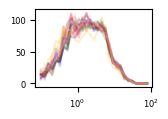

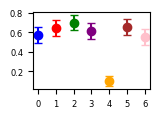

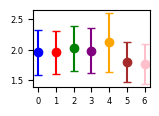

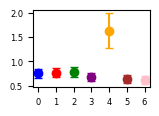

In [8]:
trials = 400
names = ["bioRNN", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike", "σRNN"]
colors = ["blue", "red", "green", "purple", "orange", "brown", "pink"]
bins = np.linspace(-1, 2, 30)
torch.manual_seed(0)
np.random.seed(0)

N = len(names)
hit_miss_mean, hit_miss_var = np.zeros((N)), np.zeros((N))
tloss_mean, tloss_var = np.zeros((N)), np.zeros((N))
nloss_mean, nloss_var = np.zeros((N)), np.zeros((N))

fig_frdistro, ax_frdistro = plot_with_size(30, 20)
ax_frdistro.set_xscale("log")
for i, log in enumerate(logs):
    opt = load_training_opt(log)
    version, step, last_step = model_version(opt.log_path)
    model = load_model_and_optimizer(opt, reload=True, last_best=version)[0]
    model.training = False
    model.to("cuda")
    (
        train_spikes,
        train_jaw,
        session_info_train,
        test_spikes,
        test_jaw,
        session_info_test,
    ) = load_data(model)
    filt = lambda x: model.filter_fun2(model.filter_fun1(x))
    name = give_name(model.opt)
    print(name)
    if name == "No spike + reset":
        continue
    torch.cuda.empty_cache()
    with torch.no_grad():
        model.opt.batch_size = trials
        stims = torch.zeros(trials, device="cuda")
        stims[::2] = 1
        state = model.steady_state()
        model.rsnn.sample_mem_noise(model.T, trials)
        mem_noise = model.rsnn.mem_noise.clone()
        input_spikes = model.input_spikes(stims)
        spikes, _, jaw, _ = model.step_with_dt(input_spikes, state, mem_noise, dt=50)        
        filt_jaw = filt(jaw)
        lick = lick_classifier(filt_jaw[-response_time:,:,0].T)
        trial_type = (1-stims) * 2 + (lick[:,0]>0.5)
        tloss, max_neurons = trial_matching_loss(
            filt(test_spikes),
            filt(spikes),
            session_info_test,
            filt(test_jaw),
            filt(jaw),
            hard_trial_matching_loss,
            model.rsnn.area_index,
            model.rsnn.excitatory_index,
        )
        mean = model.filter_fun1(train_spikes).nanmean(1).mean(0)
        std = model.filter_fun1(train_spikes).nanmean(1).std(0)
        std[std < 0.001] = 1
        nloss = neuron_loss(model, test_spikes, spikes, mean, std)
        fr_dist = spikes[:50].mean((0,1)) / model.timestep
        hr = (trial_type==1)*1.
        hr = hr[stims == 1]
        # del model
    j = names.index(name)
    div = 3 if name != "base" else 1
    hit_miss_mean[j] += hr.mean().item() / div
    hit_miss_var[j] += hr.var().item()
    tloss_mean[j] += torch.cat(tloss).mean().item() / div
    tloss_var[j] += torch.cat(tloss).var().item()
    nloss_mean[j] += nloss.mean().item() / div
    nloss_var[j] += nloss.var().item() 
    x, y = np.histogram(fr_dist.cpu().numpy().flatten(), bins=10**bins)
    ax_frdistro.plot(y[:-1], x, color=colors[j], alpha=0.2)
fig_hit, ax_hit = plot_with_size(30, 20)
for i in range(len(names)):
    ax_hit.errorbar(i, hit_miss_mean[i], yerr=1.96*np.sqrt(np.array(hit_miss_var)[i]/trials), fmt="o", capsize=3, color=colors[i])
ax_hit.set_xticks(range(len(names)))
# ax_hit.set_ylim(0.4, 0.8)
fig_hit.savefig(f"FiguresOpto/Supplementary_Figure3/hit.pdf", dpi=300, bbox_inches="tight", transparent=True)

fig_psth, ax_psth = plot_with_size(30, 20)
for i in range(len(names)):
    ax_psth.errorbar(i, nloss_mean[i], yerr=1.96*np.sqrt(np.array(nloss_var)[i]/max_neurons), fmt="o", capsize=3, color=colors[i])
ax_psth.set_xticks(range(len(names)))
fig_psth.savefig(f"FiguresOpto/Supplementary_Figure3/psth.pdf", dpi=300, bbox_inches="tight", transparent=True)

fig_ttrial, ax_ttrial = plot_with_size(30, 20)
for i in range(len(names)):
    ax_ttrial.errorbar(i, tloss_mean[i], yerr=1.96*np.sqrt(np.array(tloss_var)[i]/trials), fmt="o", capsize=3, color=colors[i])
ax_ttrial.set_xticks(range(len(names)))
fig_ttrial.savefig(f"FiguresOpto/Supplementary_Figure3/ttrial.pdf", dpi=300, bbox_inches="tight", transparent=True)
fig_frdistro.savefig(f"FiguresOpto/Supplementary_Figure3/frdistro.pdf", dpi=300, bbox_inches="tight", transparent=True)

nloss_mean, nloss_std = nloss_mean, 1.96*np.sqrt(np.array(nloss_var)/trials)
tloss_mean, tloss_std = tloss_mean, 1.96*np.sqrt(np.array(tloss_var)/max_neurons)


In [9]:
# prepare code for latex table, where first column is the name of the method, second the mean plus minus sem of the pearson correlation of the psth nofb, and third the mean plus minus sem of the pearson correlation of the psth withfb
names = ["bioRNN", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike", "σRNN"]
def latex_table(table_psth_pear_mean, table_psth_pear_std):
    for i in range(len(table_psth_pear_mean)):
        print(f"{names[i]} & {table_psth_pear_mean[i]:.2f} $\pm$ {table_psth_pear_std[i]:.2f} \\\\")

latex_table(tloss_mean, tloss_std)

bioRNN & 0.76 $\pm$ 0.14 \\
No sparsity & 0.77 $\pm$ 0.15 \\
Non-local inhibition & 0.79 $\pm$ 0.15 \\
No Dale's law & 0.68 $\pm$ 0.13 \\
No TM & 1.63 $\pm$ 0.55 \\
No spike & 0.64 $\pm$ 0.13 \\
σRNN & 0.62 $\pm$ 0.12 \\
